# In this notebook, we use Supervised Machine Learning (Random Forest in Scikit-Learn package) with classification to identify Fraudulent Medicare providers using data from CMS that has been preprocessed using Data Wrangler

## Setup

Import required libraries (install imblearn using pip if not present)

In [2]:
!pip install imblearn

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
import numpy as np 
import pandas as pd
import boto3
import os
import sagemaker
import seaborn as sns
import matplotlib.pyplot as plt
import io
import sklearn
from math import sqrt
from sagemaker import get_execution_role
from sagemaker import RandomCutForest
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer
from sagemaker.amazon.amazon_estimator import get_image_uri
from sklearn.datasets import dump_svmlight_file  
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.datasets import dump_svmlight_file   
from collections import Counter
from sagemaker.s3 import S3Downloader

%matplotlib inline

Enable the ability to see all columns and rows of data if the data size is big

In [4]:
# Allow viewing of all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# Get IAM role and SakeMaker session
role = get_execution_role()
session = sagemaker.Session()

# Set service clients
s3_client = boto3.client('s3')
#sm_client = boto3.client('sagemaker')
#smr_client = boto3.client('sagemaker-runtime')

# S3 settings
bucket = session.default_bucket() # Update as needed
prefix = 'fraud-detect-demo' # Update as needed

Let's start by reading in the entire preprocessed medicare data set prepared for classification

In [7]:
data = pd.read_csv('processed_data_classification_v2.csv', delimiter=',')
data.head()

,fraudulent_provider,female,tot_suplrs_standard_deviation,tot_suplrs_mean,tot_suplrs_sum,tot_suplr_benes_standard_deviation,tot_suplr_benes_mean,tot_suplr_benes_sum,tot_suplr_clms_standard_deviation,tot_suplr_clms_mean,tot_suplr_clms_sum,tot_suplr_srvcs_standard_deviation,tot_suplr_srvcs_mean,tot_suplr_srvcs_sum,avg_suplr_sbmtd_chrg_standard_deviation,avg_suplr_sbmtd_chrg_mean,avg_suplr_sbmtd_chrg_sum,avg_suplr_mdcr_pymt_amt_standard_deviation,avg_suplr_mdcr_pymt_amt_mean,avg_suplr_mdcr_pymt_amt_sum,bene_unique_cnt_mean,bene_unique_cnt_sum,bene_unique_cnt_standard_deviation,line_svc_cnt_mean,line_svc_cnt_sum,line_svc_cnt_standard_deviation,bene_day_srvc_cnt_mean,bene_day_srvc_cnt_sum,bene_day_srvc_cnt_standard_deviation,average_submitted_chrg_amt_mean,average_submitted_chrg_amt_sum,average_submitted_chrg_amt_standard_deviation,average_medicare_payment_amt_mean,average_medicare_payment_amt_sum,average_medicare_payment_amt_standard_deviation,total_claim_count_mean,total_claim_count_sum,total_claim_count_standard_deviation,total_30_day_fill_count_mean,total_30_day_fill_count_sum,total_30_day_fill_count_standard_deviation,total_day_supply_mean,total_day_supply_sum,total_day_supply_standard_deviation,total_drug_cost_mean,total_drug_cost_sum,total_drug_cost_standard_deviation,bene_count_mean,bene_count_sum,bene_count_standard_deviation
0,0,0,1,1,15,0,5,45,1,12,111,267,322,2900,11.178569,7.934429,71.409861,4.658956,3.499315,31.493838,25,680,16,26,711,18,26,711,18,559.399508,15103.786730,840.009002,188.998130,5102.949499,319.734687,27,1508,29,27.618182,1519.0,29.141094,384,21144,401,1834.150000,100878.25,3909.668186,18,1044,29
1,0,1,1,2,4,0,5,10,4,15,31,212,2130,4260,0.099824,6.870323,13.740646,0.025437,1.617320,3.234640,39,1649,31,43,1836,39,43,1835,39,591.405054,24839.012290,901.080266,73.985867,3107.406422,107.168763,36,1503,36,50.290244,2061.9,56.020406,1443,59170,1697,6796.406341,278652.66,9074.051325,13,564,13
2,0,0,1,2,53,0,5,95,12,18,352,919,470,8938,139.231584,104.523410,1985.944796,22.442398,18.792915,357.065393,46,3323,38,111,8025,141,83,5982,115,77.401557,5572.912117,53.623713,33.473680,2410.104952,25.844956,78,97476,123,125.475303,155463.9,217.299414,3601,4462756,6437,3199.517990,3964202.79,6778.363303,20,25385,29
3,0,0,0,1,26,0,5,70,5,19,270,714,442,6201,196.979648,142.019609,1988.274525,65.988540,58.099005,813.386077,44,3843,35,373,32531,643,148,12935,124,66.612177,5795.259439,63.047556,50.699535,4410.859539,47.831320,24,1546,14,30.934375,1979.8,26.609905,804,51480,825,11588.351410,741654.49,33653.792810,5,377,2
4,0,1,5,6,185,6,9,271,18,28,812,50,50,1478,151.662599,122.044721,3539.296899,41.279135,30.540081,885.662341,52,3683,41,65,4617,64,65,4612,64,129.947658,9096.336052,110.664136,59.952536,4196.677523,51.218031,34,14948,31,73.902961,32443.4,84.215907,2150,943978,2547,1363.546720,598597.01,2337.988826,9,4234,9


## Investigate and process the data

Check data for any nulls

In [8]:
data.isnull().values.any()

False

Check for imbalance

In [9]:
data['fraudulent_provider'].value_counts()

0    5000
1     500
Name: fraudulent_provider, dtype: int64

We see that the majority of data is non-fraudulent. We will need to rebalance the data using sampling techniques that are designed specifically for imbalanced problems to improve the performance of the model.We use the Random Under Sampler and Over Sampling techniques from imblearn to do this (http://glemaitre.github.io/imbalanced-learn/api.html)

First, remove column headers from data as SageMaker does not need headers for processing csv files

In [10]:
feature_columns = data.columns[1:]
label_column = data.columns[0]

features = data[feature_columns].values.astype('float32')
labels = (data[label_column].values).astype('float32')

We will split our dataset into a train and test to evaluate the performance of our models. Since the data is highly imbalanced, it is important to stratify across the data sets to ensure an even distribution.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, stratify=labels)

## Apply SMOTE

The ratio in oversampling and the sampling strategy for undersampling are very important in improving the performance of the models. We have selected ratios based ased on research from https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0225-0 for this dataset. However, try to expirement with different ratios to see the impact

In [12]:
# Oversample the minority class with SMOTE to a 1:4 ratio
over = SMOTE(sampling_strategy=0.25)

# Undersample the majority class to achieve about a 1:1 ratio.
# The minority class will be the same amount (1 to 1) as the majority class
under = RandomUnderSampler(sampling_strategy=1)

# Add steps to parameter list
steps = [('o', over), ('u', under)]

# Create imblearn.pipeline and pass steps
pipeline = Pipeline(steps=steps)

# Fit and apply to the CMS dataset in a single transform
X_smote, y_smote = pipeline.fit_resample(X_train, y_train)

In [13]:
print(sorted(Counter(y_smote).items()))

[(0.0, 1125), (1.0, 1125)]


In [14]:
X_smote_train, X_smote_validation, y_smote_train, y_smote_validation = train_test_split(
    X_smote, y_smote, test_size=0.1, stratify=y_smote)

## Training and Prediction - Supervised learning (Random Forest classification)

We use a supervised learning algorithm for classifcation using Scikit-Learn Random Forest 

### Prepare Data and Upload to S3

We first save the data in csv format and then upload the data to S3 

In [15]:
# first column is target column
trainX_concate = np.concatenate((y_smote_train.reshape(len(y_smote_train),1), X_smote_train), axis=1)
trainX = pd.DataFrame(trainX_concate, index=None, columns=None)

validationX_concate = np.concatenate((y_smote_validation.reshape(len(y_smote_validation),1), X_smote_validation), axis=1)
validationX = pd.DataFrame(validationX_concate, index=None, columns=None)

testX = pd.DataFrame(X_test, index=None, columns=None)

In [16]:
trainX.to_csv("cms_payment_train.csv", header=False, index=False)
validationX.to_csv("cms_payment_validation.csv", header=False, index=False)
testX.to_csv("cms_payment_test.csv", header=False, index=False)

Now we upload the data to S3. SageMaker will take training data from s3

In [17]:
train_path = session.upload_data(
    path="cms_payment_train.csv", bucket=bucket, key_prefix=prefix
)

validation_path = session.upload_data(
    path="cms_payment_validation.csv", bucket=bucket, key_prefix=prefix
)

test_path = session.upload_data(
    path="cms_payment_test.csv", bucket=bucket, key_prefix=prefix
)

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-240487350066/fraud-detect-demo/output


## Writing a *Script Mode* script
The below script contains both training and inference functionality and can run in SageMaker Training hardware. Detailed guidance here https://sagemaker.readthedocs.io/en/stable/using_sklearn.html#preparing-the-scikit-learn-training-script

In [18]:
%%writefile script.py

import argparse
import joblib
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


# inference functions ---------------
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf


if __name__ == "__main__":

    print("extracting arguments")
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    # to simplify the demo we don't use all sklearn RandomForest hyperparameters
    parser.add_argument("--n-estimators", type=int, default=10)
    parser.add_argument("--min-samples-leaf", type=int, default=3)

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="cms_payment_train.csv")
    parser.add_argument("--test-file", type=str, default="cms_payment_validation.csv")

    args, _ = parser.parse_known_args()

    print("reading data")
    train_df = pd.read_csv(os.path.join(args.train, args.train_file), header=None)
    test_df = pd.read_csv(os.path.join(args.test, args.test_file), header=None)

    print("building training and testing datasets")
    X_train = train_df[train_df.columns[1:]]
    X_test = test_df[test_df.columns[1:]]
    y_train = train_df[train_df.columns[0]]
    y_test = test_df[test_df.columns[0]]

    # train
    print("training model")
    model = RandomForestClassifier(
        n_estimators=args.n_estimators, min_samples_leaf=args.min_samples_leaf, n_jobs=-1
    )

    model.fit(X_train, y_train)

    # print accuracy
    print("validating model")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print(f"Accuracy is: {acc}")
    print(f"Area under the curve is: {auc}")

    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print("model persisted at " + path)
    print(args.min_samples_leaf)

Writing script.py


## SageMaker Training

### Launching a training job with SageMaker Python SDK

In [19]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="rf-scikit",
    metric_definitions=[{"Name": "Accuracy", "Regex": "Accuracy is: ([0-9.]+).*$"}],
    hyperparameters={
        "n-estimators": 100,
        "min-samples-leaf": 2
    },
)

In [20]:
# launch training job, with asynchronous call
sklearn_estimator.fit({"train": train_path, "test": validation_path}, wait=True)

2022-09-23 16:04:46 Starting - Starting the training job...ProfilerReport-1663949086: InProgress
.........
2022-09-23 16:06:43 Starting - Preparing the instances for training......
2022-09-23 16:07:44 Downloading - Downloading input data...
2022-09-23 16:08:10 Training - Downloading the training image...
2022-09-23 16:08:44 Uploading - Uploading generated training model2022-09-23 16:08:32,981 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-09-23 16:08:32,984 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-23 16:08:32,993 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-09-23 16:08:33,412 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-23 16:08:33,430 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-23 16:08:33,442 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus 

## Batch Transform <a class="anchor" id="batch_transform"></a>
We can also use the trained model for asynchronous batch inference on S3 data using SageMaker Batch Transform.

In [21]:
# Define an SKLearn Transformer from the trained SKLearn Estimator
transformer = sklearn_estimator.transformer(instance_count=1, instance_type="ml.m5.xlarge", strategy='MultiRecord', assemble_with="Line", accept="text/csv")

In [22]:
# Start a transform job and wait for it to finish
transformer.transform(test_path, split_type="Line", content_type="text/csv")
print("Waiting for transform job: " + transformer.latest_transform_job.job_name)
transformer.wait()

............................2022-09-23 16:44:34,547 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-09-23 16:44:34,550 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-09-23 16:44:34,551 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      retu

### Check Output Data  <a class="anchor" id="check_output_data"></a>
After the transform job has completed, download the output data from S3. For each file "f" in the input data, we have a corresponding file "f.out" containing the predicted labels from each input row. We can compare the predicted labels to the true labels saved earlier.

In [23]:
# Download the output data from S3 to local file system
batch_output = transformer.output_path
output_file_name = "cms_payment_test.csv.out"

!aws s3 cp {batch_output}/{output_file_name} ./

download: s3://sagemaker-us-east-1-240487350066/rf-scikit-2022-09-23-16-39-59-542/cms_payment_test.csv.out to ./cms_payment_test.csv.out


In [24]:
from numpy import genfromtxt
y_preds = genfromtxt(output_file_name, delimiter=',') 
y_preds.shape

(550,)

### Evaluation

We will use a few measures from the scikit-learn package to evaluate the performance of our model. When dealing with an imbalanced dataset, we need to choose metrics that take into account the frequency of each class in the data.

We will use [balanced accuracy score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)


we can bring a balance between the metrics again by adjusting our classification threshold (threshold between labeling a point as fraud or not). We can try different thresholds to see if they affect the result of the classification. 

In [25]:
# Calculate balanced accuracy score
print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, y_preds)))

Balanced accuracy = 0.773


Apart from single-value metrics, it's also useful to look at metrics that indicate performance per class. A confusion matrix, and per-class precision, recall and f1-score can also provide more information about the model's performance.

In [27]:
def plot_confusion_matrix(y_true, y_predicted):

    cm  = confusion_matrix(y_true, y_predicted)
    # Get the per-class normalized value for each cell
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # We color each cell according to its normalized value, annotate with exact counts.
    ax = sns.heatmap(cm_norm, annot=cm, fmt="d")
    ax.set(xticklabels=["non-fraud", "fraud"], yticklabels=["non-fraud", "fraud"])
    ax.set_ylim([0,2])
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()

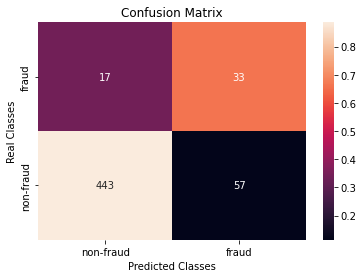

In [28]:
plot_confusion_matrix(y_test, y_preds)

In [29]:
print(classification_report(
    y_test, y_preds, target_names=['non-fraud', 'fraud']))

              precision    recall  f1-score   support

   non-fraud       0.96      0.89      0.92       500
       fraud       0.37      0.66      0.47        50

    accuracy                           0.87       550
   macro avg       0.66      0.77      0.70       550
weighted avg       0.91      0.87      0.88       550




## Data Acknowledgements

The dataset used to demonstrated the fraud detection solution has been collected and analysed from CMS 

https://data.cms.gov/provider-summary-by-type-of-service/medicare-physician-other-practitioners/medicare-physician-other-practitioners-by-provider-and-service

